#  Прогнозирование заказов такси

**План проекта:**
        
1. Описание задачи 
2. Подготовка данных
3. Анализ данных
4. Обучение моделей
5. Анализ моделей
6. Тестирование лучшей модели
7. Итоговый вывод

## Описание задачи

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нам нужно построить модель для такого предсказания.

При этом значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка данных

In [1]:
# импортируем библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error 
from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# прочитаем датасет

try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net//datasets/datasets/autos.csv')

In [3]:
# посмотрим на данные

data.sort_index(inplace=True)
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Мы имеем два столбца:  
  
- `datetime` - даты с формате год-месяц-день и время в формате час-минута-секунда
- `num_orders` - количество заказов такси в указанную дату, время  
  
Шаг в дате 10 минут. 

In [4]:
# посмотрим на типы данных

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# проверим количество пропусков

data.isna().sum()

num_orders    0
dtype: int64

In [6]:
# проверим в хронологическом ли порядке расположены данные

data.index.is_monotonic

True

In [7]:
# выведем данные для проверки

display(data.head())
display(data.tail())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


Итак, у нас имеется временой промежуток с 2018-03-01 до 2018-08-31, то есть с марта по август.   
При этом шаг у нас 10 минут. В соотвествие с нашей задачей, ресемплируем данные по одному часу..

In [8]:
# ресемплируем данные по 1 часу

data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


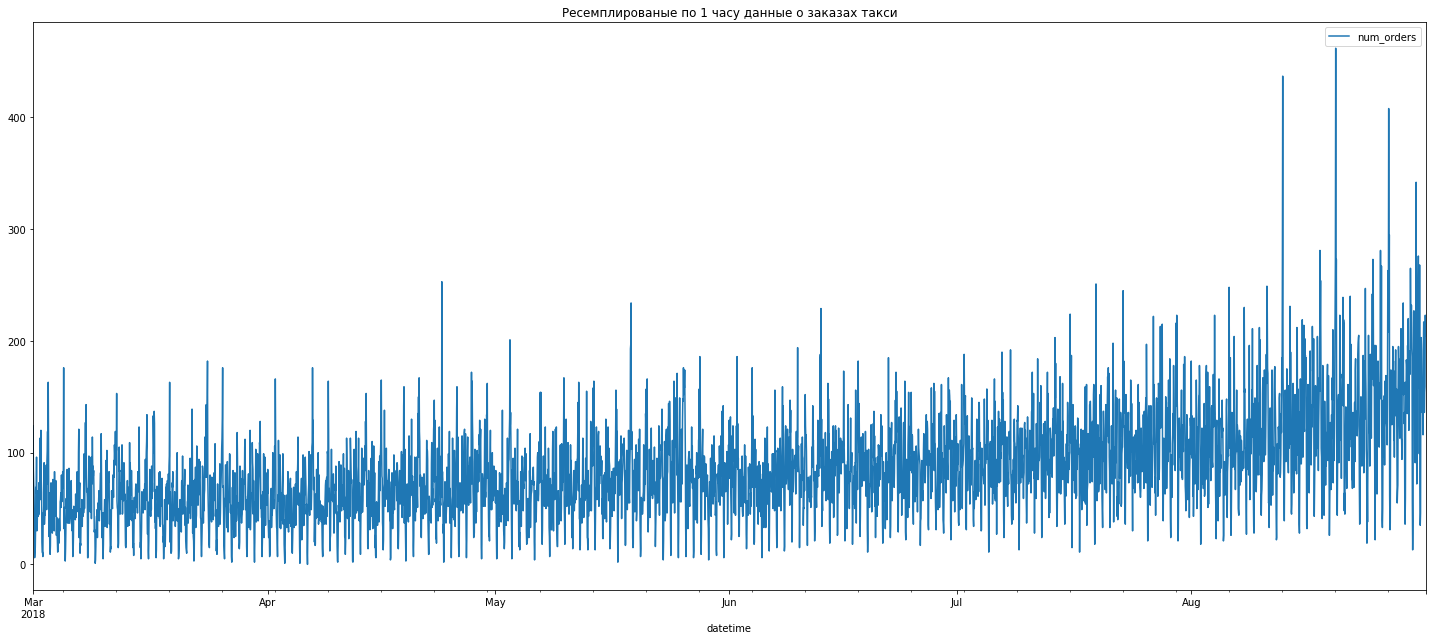

In [9]:
# посмотрим данные на графике

figsize = (20,9)

data.plot(figsize=figsize, ax=plt.gca() )
plt.title('Ресемплированые по 1 часу данные о заказах такси');
plt.tight_layout()

График очень плотный и не информативный. Подведем итоги этого шага и передейдем к анализу.

**Вывод по подготовке данных:**
  
- данные с 2018-03-01 до 2018-08-31
- поменяли тип данных у datetime и сделали индексы по этому столбцу
- пропусков нет, дубли искать нет смысла, имеем сезонность и значит количество заказов может повторяться
- шаг был в 10 минут, провели ресемплирование по 1 часу для удобства работы с данными

## Анализ данных

Перейдем к анализу имеющихся данных. Посмотрим на скользящее среднее, сезонность и тренды. 

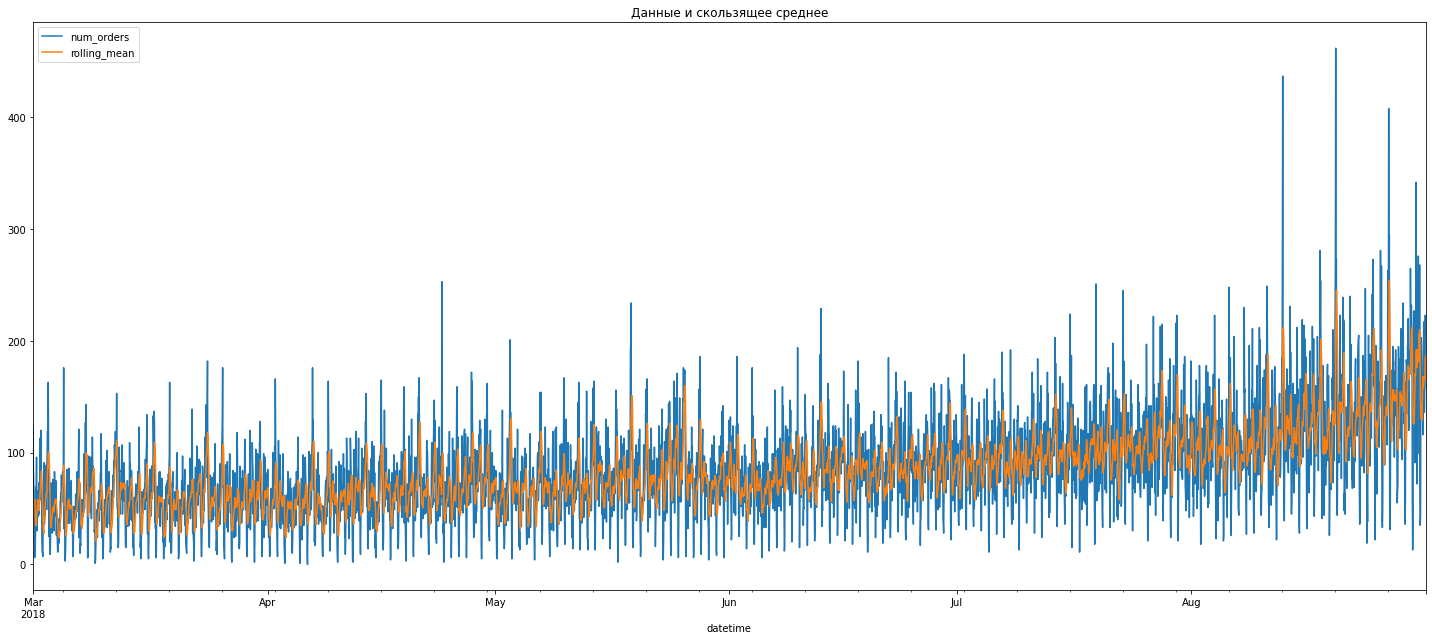

In [10]:
# посмотрим распределение данных с учетом скользящего среднего

data_copy = data.copy()
data_copy['rolling_mean'] = data_copy.rolling(7).mean()

data_copy.plot(figsize=figsize, ax=plt.gca())
plt.title('Данные и скользящее среднее');
plt.tight_layout()

Данные имеют большие колебания. Видно возрастание. Посмотрим на тренды, сезонность и остаток.  

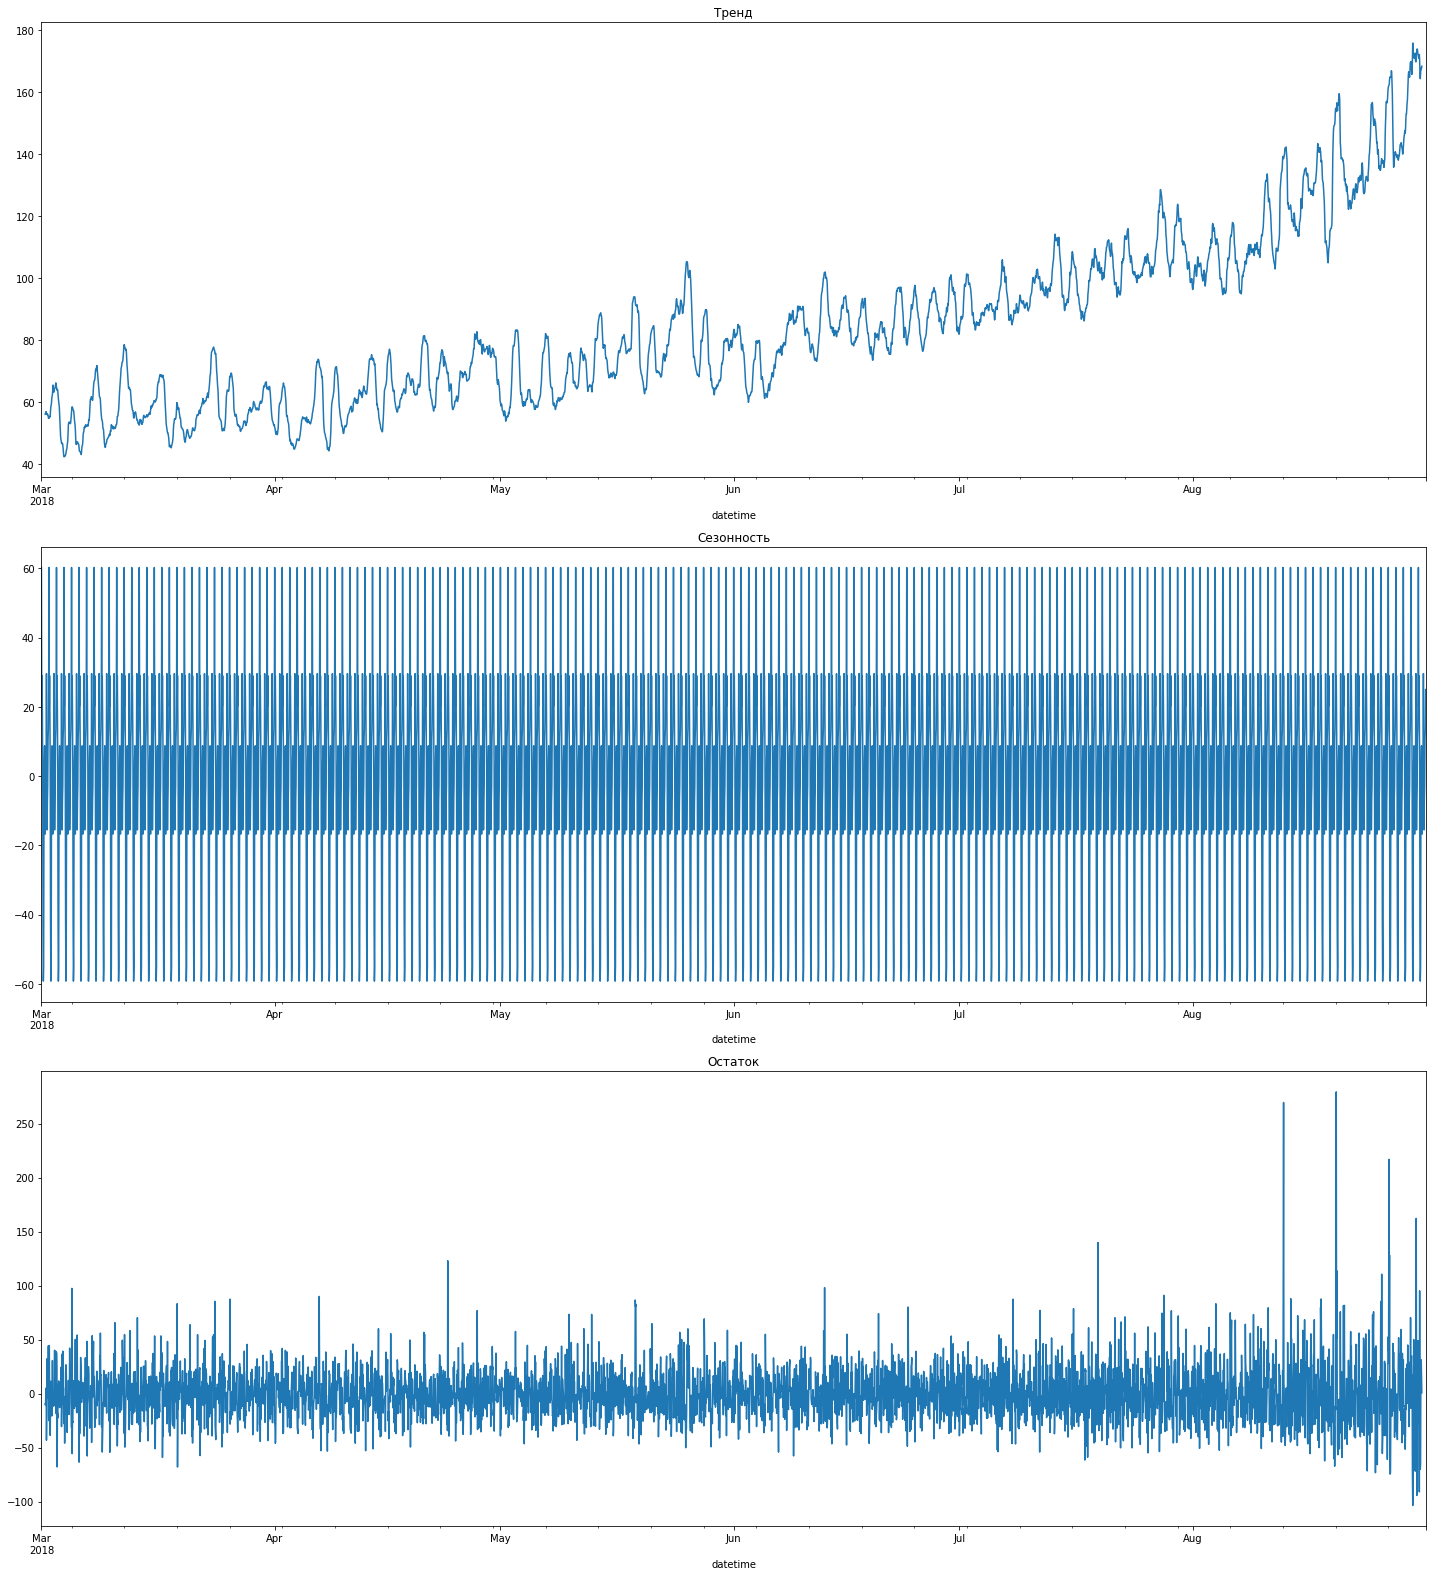

In [11]:
# построим графики тренда, сезонности и остатка за весь период

decomposed = seasonal_decompose(data)

plt.figure(figsize= (20,22))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Тренд виден, а вот сезонность слишком плотные график. Посмотрим все это на данных за неделю и за день. Возьмем последнюю неделю августа и 30-31 агуста. 

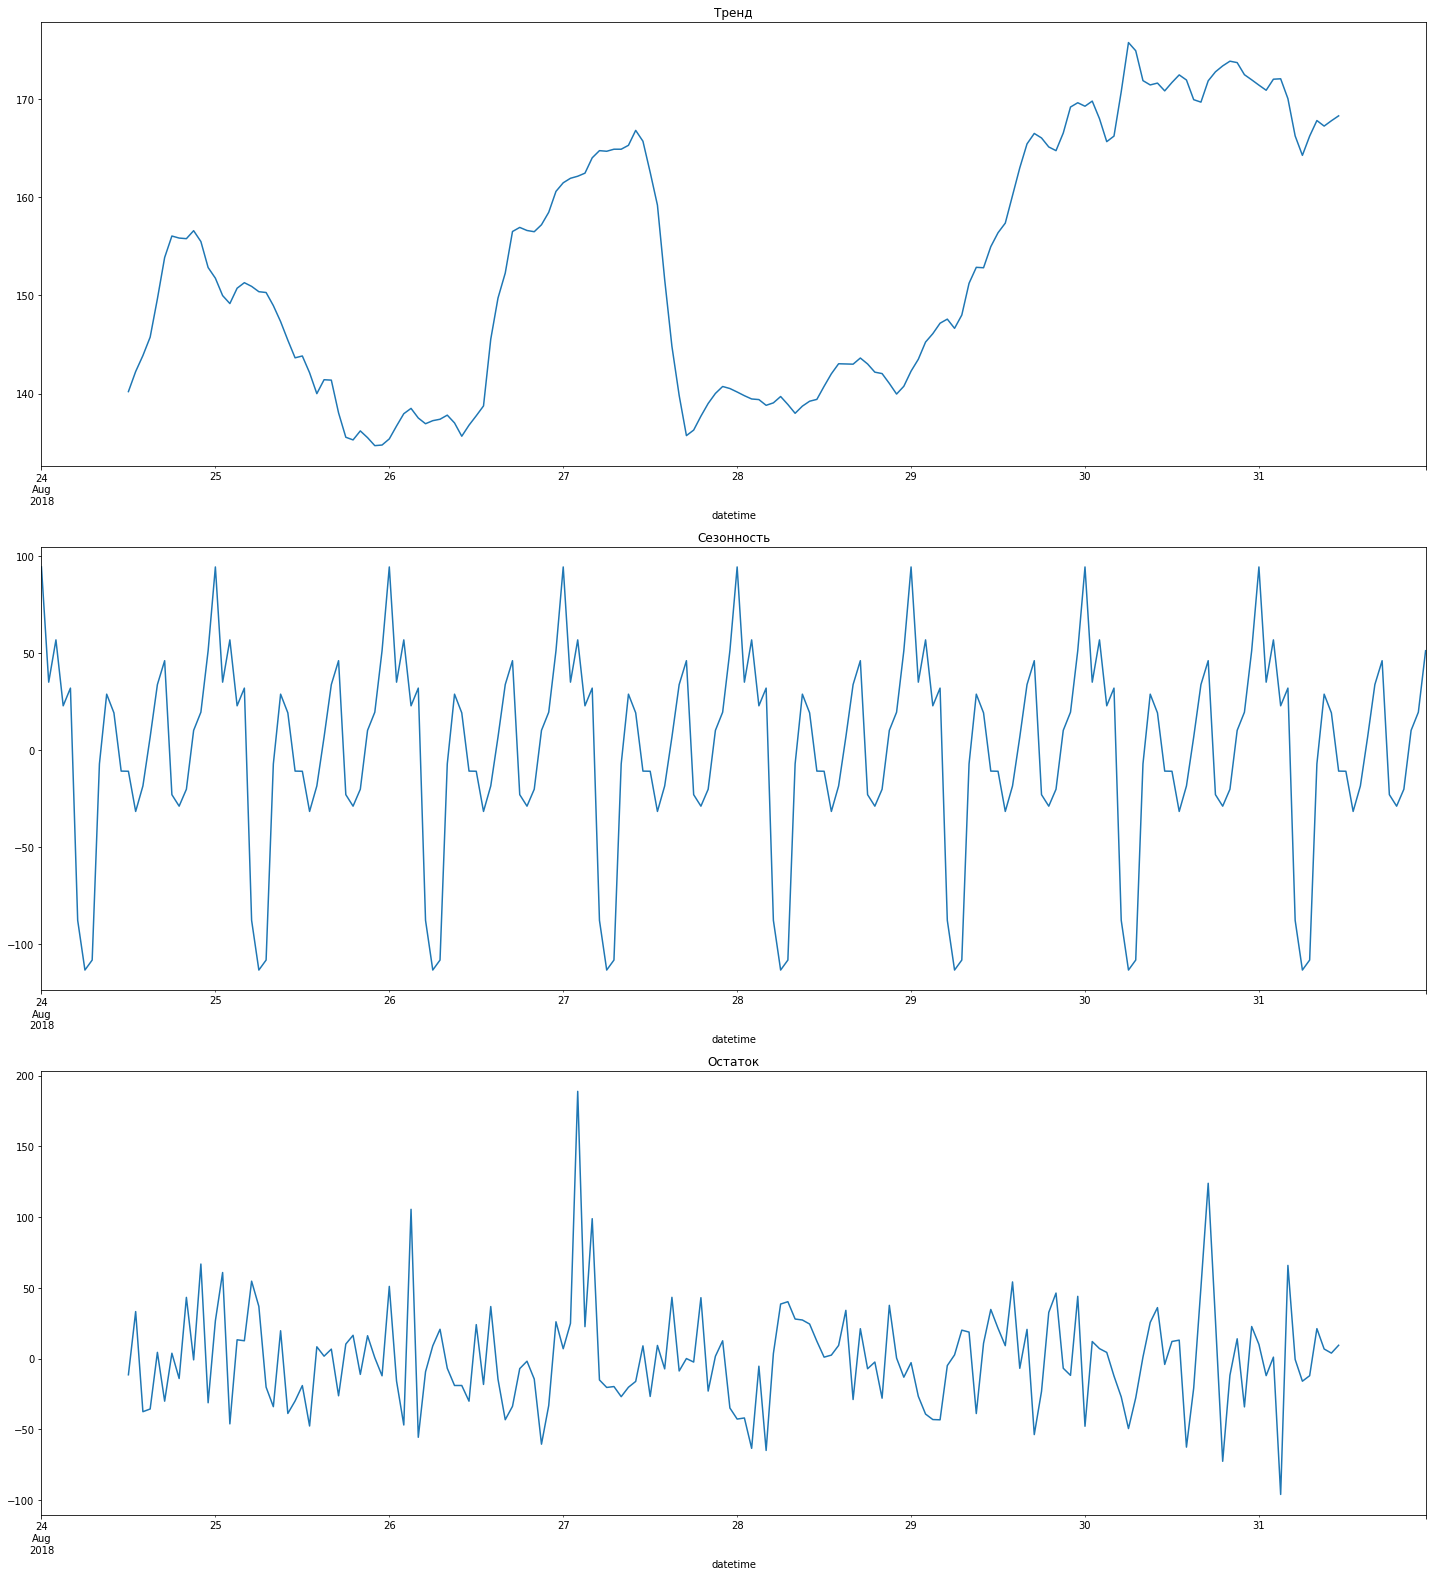

In [12]:
# построим графики тренда, сезонности и остатка за неделю

decomposed_week = seasonal_decompose(data['2018-08-24':'2018-08-31'])

plt.figure(figsize= (20,22))

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

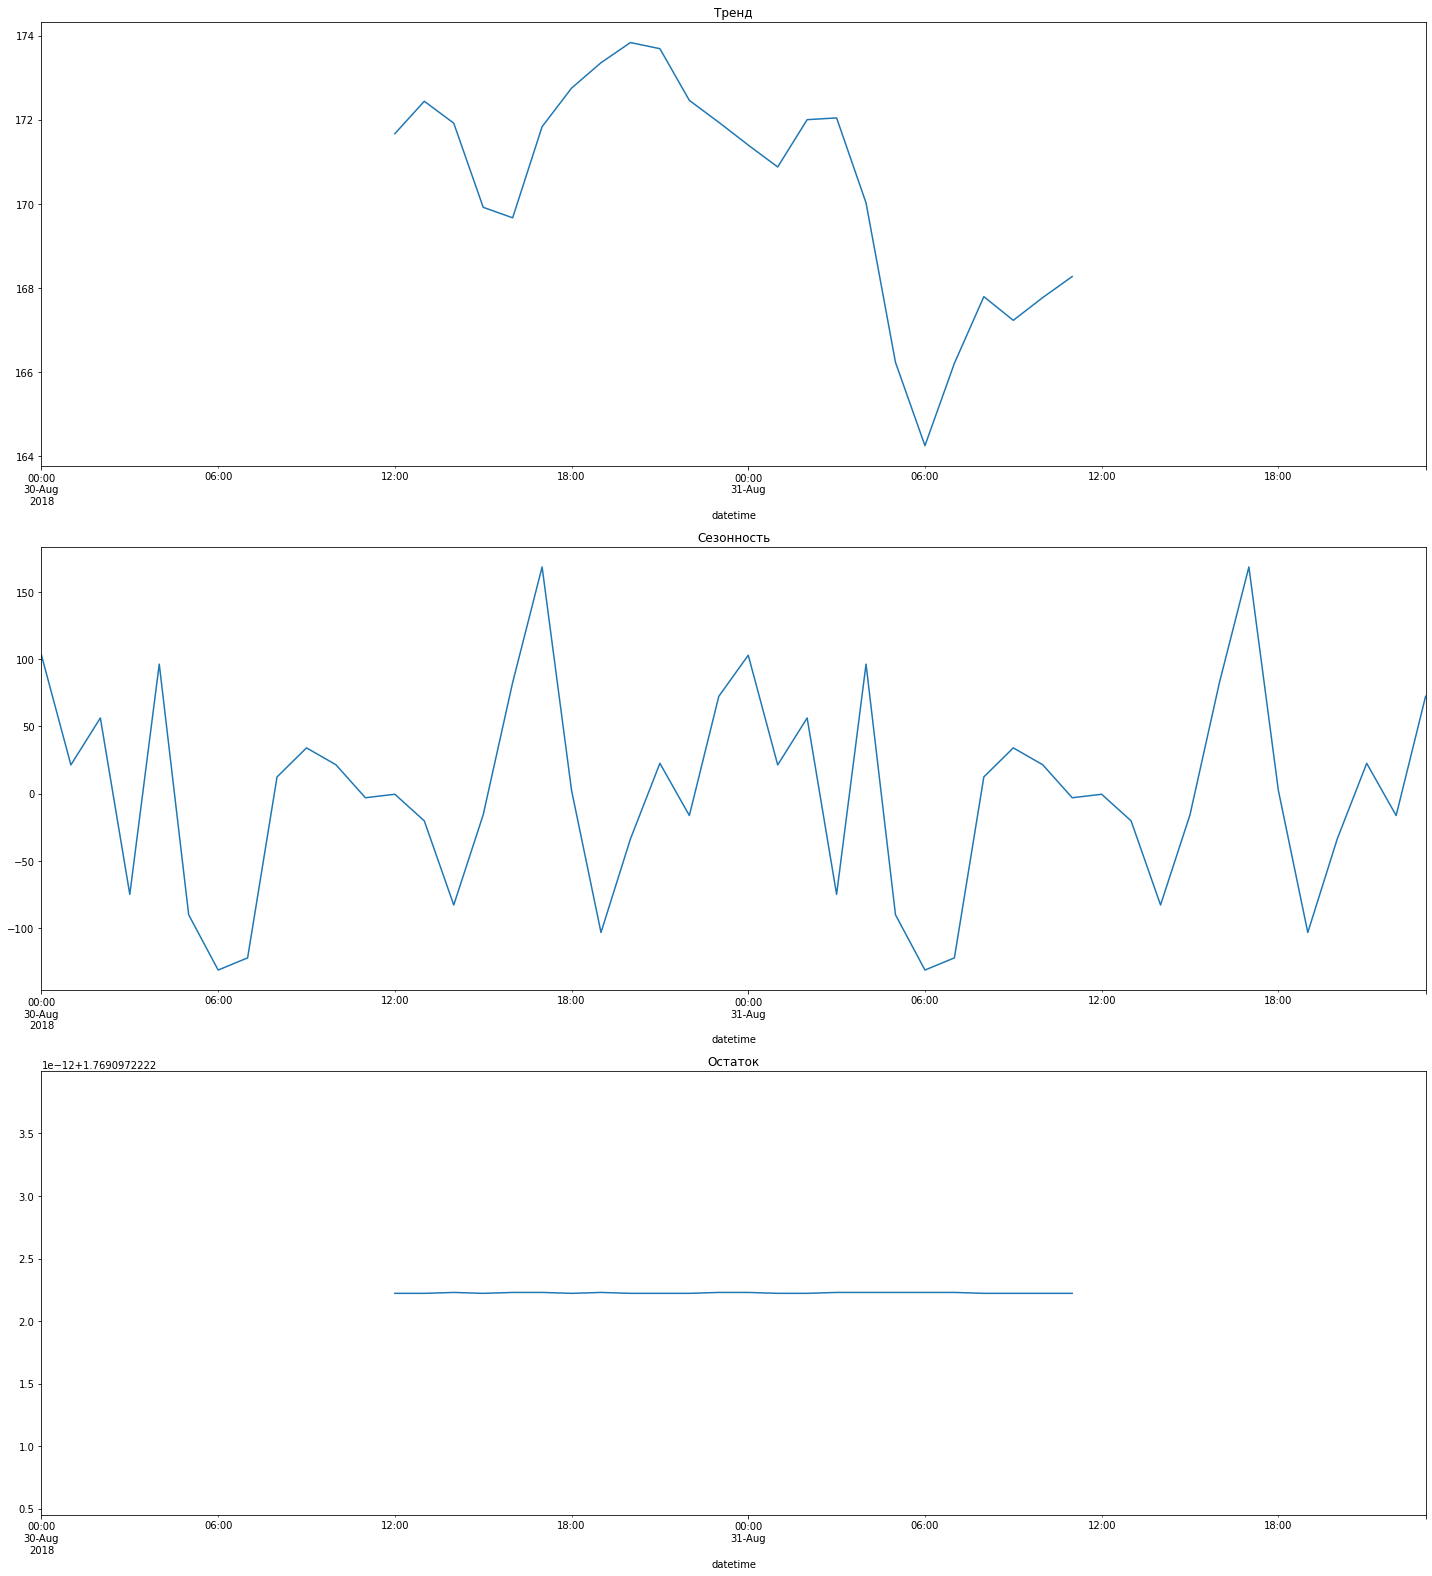

In [13]:
# построим графики тренда, сезонности и остатка за два дня

decomposed_day = seasonal_decompose(data['2018-08-30':'2018-08-31'])

plt.figure(figsize= (20,22))

plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed_day.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Мы видим, что действительно есть сезонность и растущий тренд. К 18 вечера заказы растут, потом падают (возможно из-за самых сильных пробок с 18.00 и примерно до 20.00), а затем снова растет и падает только после 1-2 часов ночи. Самая низкая активность в 6-7 утра.  Видно, что ряд не стационарный. 
  
Построим график скользящего среднего и скользящего стандартного отклонения для разницы временных рядов.


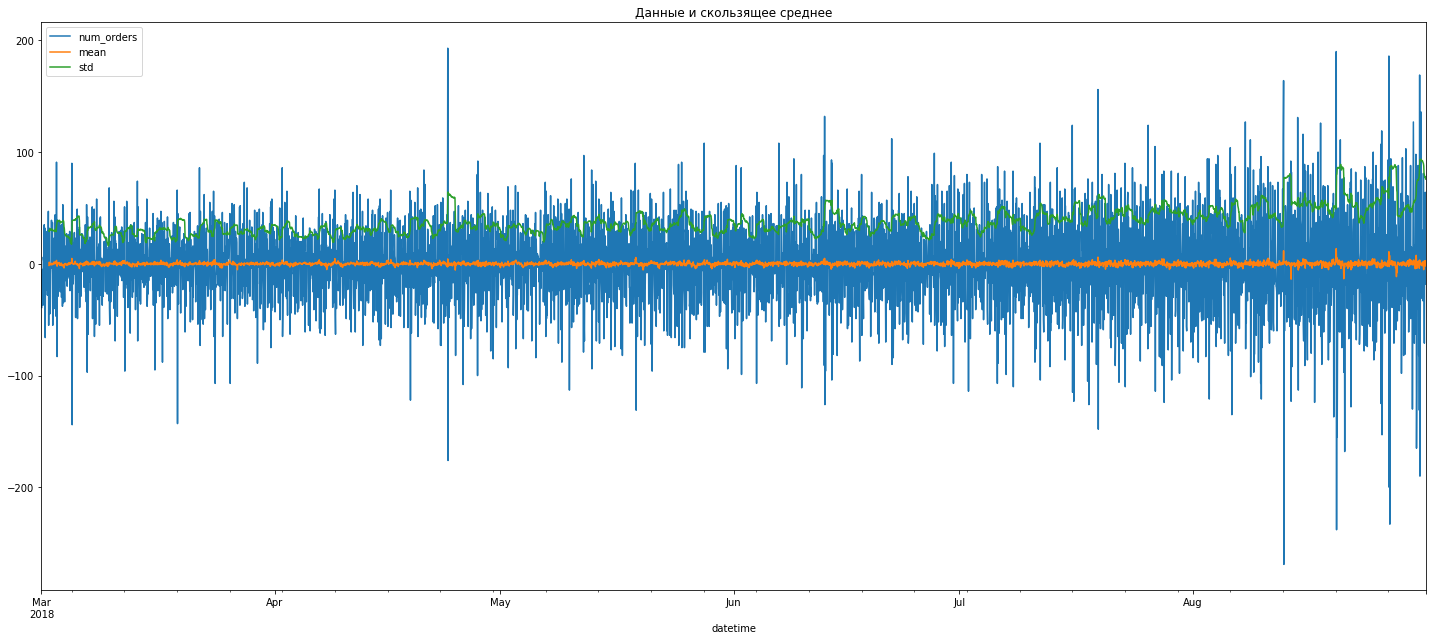

In [14]:
# найдем разницу временных рядов
# построим график скользящего среднего и скользящего стандартного отклонения

data_shift = data - data.shift()

data_shift['mean'] = data_shift['num_orders'].rolling(24).mean()
data_shift['std'] = data_shift['num_orders'].rolling(24).std()

data_shift.plot(figsize=figsize, ax=plt.gca())
plt.title('Данные и скользящее среднее');
plt.tight_layout()

**Вывод на этапе анализа данных:**  
  
- мы выявили растущий тренд на заказы такси, что может быть связано с увеличением использования такси в целом (гипотеза)
- есть сезонность заказов: рост с обеда и до 17, спад на вечерние пробки и рост с 20 до 1-2 ночи, самая низкая активность в 6-7 утра
- временной ряд не стационарный

## Обучение моделей

Перед обучением моделей создадим функцию для создания признаков и разделим данные на выборки.

### Подготовка признаков и выборок

In [15]:
# зададим функцию для создания признаков

def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [16]:
# зададим признаки

make_features(data, 24, 48)

In [17]:
# посмотрим на получившуюся таблицу

data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разобьем данные на выборки и удалим пропуски из обучающей выборки.

In [18]:
# разделим данные на обучающую и тестовую выборку

train, test = train_test_split(data, shuffle=False, test_size=0.1)

train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [19]:
# проверим размер выборок

for data in features_train, target_train, features_test, target_test:
    print(data.shape)

(3926, 27)
(3926,)
(442, 27)
(442,)


Итак, выборки готовы, начнем обучать модели.

### Линейная регрессия

In [20]:
# зададим cross validator

cross_validator = TimeSeriesSplit(n_splits=8).split(features_train)

In [21]:
%%time

# обучим модель линейной регрессии с кросс-валидацией

start = time.time()

model_lin_reg = LinearRegression()

score_lin_reg = cross_val_score(model_lin_reg,
                                features_train, 
                                target_train, 
                                scoring='neg_root_mean_squared_error',
                                cv=TimeSeriesSplit(n_splits=8).split(features_train))

rmse_lin_reg = np.mean(abs(score_lin_reg))

train_time_lin_reg = time.time() - start

print('RMSE:', round(rmse_lin_reg))
print('Время обучения:', round(train_time_lin_reg,2))
print()

RMSE: 27
Время обучения: 0.79

CPU times: user 289 ms, sys: 560 ms, total: 848 ms
Wall time: 789 ms


Линейная регрессия показывает результ RMSE 28. 

### Дерево решений

In [22]:
state = RandomState(12345)

In [23]:
%%time

# обучим модель дерево решений с кросс-валидацией

start = time.time()

best_model_tree = None
best_result_tree = 50

scores_tree = []

for depth in range(1, 30, 1):
    
    model_tree = DecisionTreeRegressor(max_depth=depth, random_state=state)
    
    cross_validator = TimeSeriesSplit(n_splits=8).split(features_train)
    
    scores_tree = cross_val_score(model_tree,
                                  features_train,
                                  target_train,
                                  scoring='neg_root_mean_squared_error',
                                  cv= cross_validator) #TimeSeriesSplit(n_splits=8).split(features_train))

    rmse_tree = np.mean(abs(scores_tree))
    
    if rmse_tree < best_result_tree:
        best_model_tree = model_tree
        best_result_tree = rmse_tree
        
train_time_tree = time.time() - start

print('Параметры лучшей модели:', best_model_tree)
print('RMSE:', round(best_result_tree))
print('Время обучения:', round(train_time_tree,2))
print()

Параметры лучшей модели: DecisionTreeRegressor(max_depth=6,
                      random_state=RandomState(MT19937) at 0x7F09A0A23D40)
RMSE: 29
Время обучения: 8.0

CPU times: user 7.96 s, sys: 28.7 ms, total: 7.99 s
Wall time: 8 s


Модель дерево решения показала результат RMSE 29 и глубину 6.

### CatBoost

In [24]:
%%time

# обучим модель CatBoostRegressor

start = time.time()

model_cat = CatBoostRegressor()
parameteres = ({'learning_rate': [0.1, 0.2, 0.4],
               'random_state':[12345],
               'verbose': [400]})

grid = GridSearchCV(model_cat, 
                    parameteres,
                    scoring='neg_root_mean_squared_error',
                    cv = TimeSeriesSplit(n_splits=8), 
                    n_jobs=-1)

grid.fit(features_train, target_train)

rmse_cat = grid.best_score_*-1

train_time_cat = time.time() - start

print()
print('RMSE:', round(rmse_cat))
print('Параметры лучшей модели:', grid.best_params_)
print('Время обучения:', round(train_time_cat,2))
print()

0:	learn: 27.5994733	total: 50ms	remaining: 50s
400:	learn: 1.2137934	total: 1.04s	remaining: 1.56s
800:	learn: 0.1070449	total: 2.03s	remaining: 503ms
999:	learn: 0.0334863	total: 2.52s	remaining: 0us
0:	learn: 28.0906347	total: 4.67ms	remaining: 4.67s
400:	learn: 3.7166083	total: 1.21s	remaining: 1.81s
800:	learn: 0.9804692	total: 2.42s	remaining: 600ms
999:	learn: 0.5351568	total: 3s	remaining: 0us
0:	learn: 29.1673355	total: 4.51ms	remaining: 4.5s
400:	learn: 5.6220188	total: 1.3s	remaining: 1.94s
800:	learn: 2.0398153	total: 2.57s	remaining: 639ms
999:	learn: 1.2809637	total: 3.33s	remaining: 0us
0:	learn: 30.1150381	total: 5.5ms	remaining: 5.5s
400:	learn: 7.1769383	total: 1.4s	remaining: 2.1s
800:	learn: 3.1784396	total: 2.81s	remaining: 698ms
999:	learn: 2.1613351	total: 3.51s	remaining: 0us
0:	learn: 31.4400841	total: 5.17ms	remaining: 5.16s
400:	learn: 8.2205431	total: 1.53s	remaining: 2.28s
800:	learn: 4.1050823	total: 3.14s	remaining: 779ms
999:	learn: 2.9116231	total: 3.93

Модель CatBoost показала RMSE 24 с параметрами learning_rate = 0.1

### LightGBM

In [25]:
%%time

# обучим модель LightGBMRegressor

start = time.time()

model_lgbm = lgb.LGBMRegressor()
parameteres = ({'learning_rate': [0.1, 0.2, 0.3, 0.4],
               'random_state':[12345]})

grid = GridSearchCV(model_lgbm, 
                    parameteres,
                    scoring='neg_root_mean_squared_error',
                    cv = TimeSeriesSplit(n_splits=8), 
                    n_jobs=-1)

grid.fit(features_train, target_train)

rmse_lgbm = grid.best_score_*-1

train_time_lgbm = time.time() - start

print()
print('RMSE:', round(rmse_lgbm))
print('Параметры лучшей модели:', grid.best_params_)
print('Время обучения:', round(train_time_lgbm,2))
print()


RMSE: 25
Параметры лучшей модели: {'learning_rate': 0.1, 'random_state': 12345}
Время обучения: 30.31

CPU times: user 30.1 s, sys: 211 ms, total: 30.3 s
Wall time: 30.3 s


Модель LightGBM показала RMSE 25 с learning_rate = 0.1

### Проверка качества

In [26]:
# спрогнозируем временные ряды без обучения для проверки качества моделей

start = time.time()

pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

rmse_check_model = mean_squared_error(target_test, pred_previous) ** .5

train_time_check = time.time() - start

print()
print('RMSE для проверки модели на адекватность:', round(rmse_check_model))
print('Время обучения:', round(train_time_check,3))
print()


RMSE для проверки модели на адекватность: 59
Время обучения: 0.001



На проверке качества мы имеем RMSE 59.   
  
Сведем все результаты в таблицу и проанализируем получившиеся данные.

## Анализ моделей 

In [27]:
# создадим сводную таблицу 

index = ['Linear Regression',
         'Decision Tree Regressor',
         'Cat Boost Regressor',
         'LGBM Regressor',
         'Check Model']

data = {'RMSE train':[round(rmse_lin_reg),
                      round(best_result_tree),
                      round(rmse_cat),
                      round(rmse_lgbm),
                      round(rmse_check_model)],
        
        'Время обучения':[round(train_time_lin_reg,3),
                          round(train_time_tree,3),
                          round(train_time_cat,3),
                          round(train_time_lgbm,3),
                          round(train_time_check,3)],
       }

kpi_data = pd.DataFrame(data=data, index=index)
kpi_data

,RMSE train,Время обучения
Linear Regression,27,0.788
Decision Tree Regressor,29,7.998
Cat Boost Regressor,24,152.687
LGBM Regressor,25,30.307
Check Model,59,0.001


**Вывод:**  
   
- линейная регрессия RMSE 27
- дерево решений RMSE 29
- CatBoost RMSE 24
- LightGBM RMSE 25
- проверка качества показала RMSE 59, что подтвердило адекватность наших моделей    
   
Лучший показатель RMSE 24 дает модель `CatBoostRegregressor`. Поэтому на тесте проверим будем ее.

## Тестирование лучшей модели

Проверим на тестовой выборке модель и сравним результат с необходимым нам по задаче.

In [28]:
%%time

# протестируем модель CatBoost

model_cat = CatBoostRegressor(learning_rate=0.1,
                              random_state=12345,
                              verbose=200)

model_cat.fit(features_train, target_train)

prediction_cat= model_cat.predict(features_test)

rmse_cat_test = mean_squared_error(target_test, prediction_cat) ** .5

print('RMSE:', round(rmse_cat_test))

0:	learn: 36.9532157	total: 5.57ms	remaining: 5.56s
200:	learn: 16.3437598	total: 982ms	remaining: 3.9s
400:	learn: 12.6911517	total: 2s	remaining: 2.98s
600:	learn: 10.0932088	total: 2.96s	remaining: 1.96s
800:	learn: 8.0959637	total: 3.96s	remaining: 984ms
999:	learn: 6.5788791	total: 4.93s	remaining: 0us
RMSE: 40
CPU times: user 5.03 s, sys: 50.5 ms, total: 5.08 s
Wall time: 7.53 s


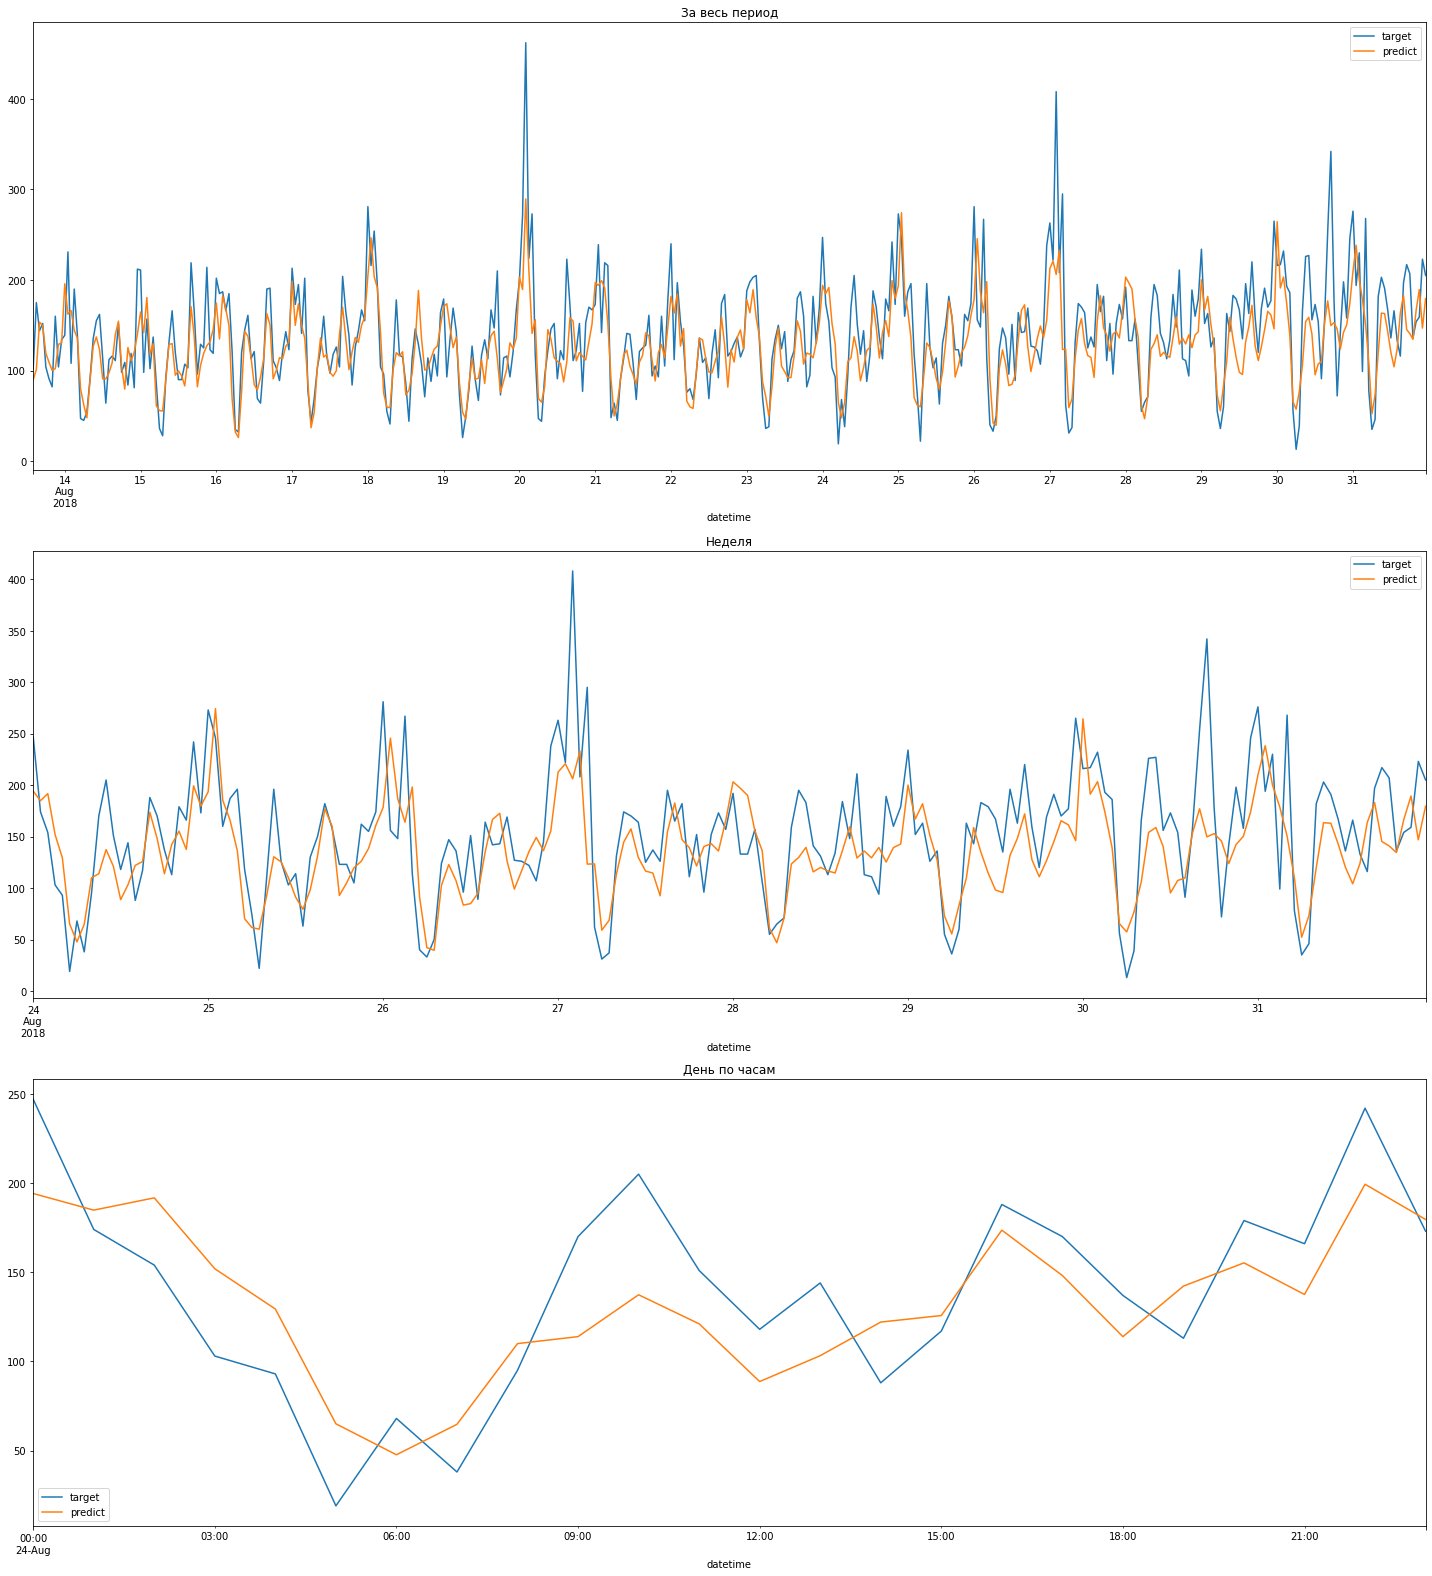

In [29]:
# построим график данных и предсказаний

model_tree_data = pd.DataFrame({"target":target_test, "predict":prediction_cat})

plt.figure(figsize= (20,22))

plt.subplot(311)
model_tree_data.plot(ax=plt.gca())
plt.title('За весь период')

plt.subplot(312)
model_tree_data['2018-08-24':'2018-08-31'].plot(ax=plt.gca())
plt.title('Неделя')

plt.subplot(313)
model_tree_data['2018-08-24'].plot(ax=plt.gca())
plt.title('День по часам')
plt.tight_layout()

Модель довольно хорошо справилась с предсказанием. RMSE на тестовой выборке равен 40 и время работы намного ниже, чем на обучении.  
По графикам видно, что модель не всегда точно попадает в пики активности, но достаточно часто и близко к ним. 

## Итоговый вывод

Перед нами стояла задача построить модель для прогнозирования количества заказов такси на следующий час в период пиковой активности для компания «Чётенькое такси». Нам передали исторические данные компании для анализа и обучения модели. Важный фактор выбора модели - значение метрики *RMSE* на тестовой выборке должно быть не больше 48.  
  
В ходе работы мы проделали следущие шаги:   
  
**1. Загрузили и подготовили данные:**  
      
   - данные с 2018-03-01 до 2018-08-31
   - поменяли тип данных у datetime и сделали индексы по этому столбцу
   - пропусков нет, дубли искать нет смысла, имеем сезонность и значит количество заказов может повторяться
   - шаг был в 10 минут, провели ресемплирование по 1 часу для удобства работы с данными
  
**2. Провели анализ данных:**  
  
  - мы выявили растущий тренд на заказы такси, что может быть связано с увеличением использования такси в целом (гипотеза)
  - есть сезонность заказов: рост с обеда и до 17, спад на вечерние пробки и рост с 20 до 1-2 ночи, самая низкая активность в 6-7 утра
  - временной ряд не стационарный 
  - была найдена разница временных рядов и построен график  
     
**3. Обучили модели:**  
  
  - линейная регрессия RMSE 27
  - дерево решений RMSE 29
  - CatBoost RMSE 24
  - LightGBM RMSE 25
  - проверка качества показала RMSE 59, что подтвердило адекватность наших моделей  
  
**4. Проверили модель на тестовой выборке:**  
  
  - CatBoost RMSE 40
  - построили график сравнения реальных показателей с предсказаниями
  - по графику видно, что модель не всегда точно попадает в пики активности, но достаточно часто и близко к ним
    
По этим данным мы видим, что выбранная модель CatBoost дает хороший результат при максимальном отставании 24 часа и шириной окна 48 часов. 

**Вывод:** лучшая модель для прогнозирования количества заказов такси на следующий час в период пиковой активности - CatBoostRegressor. 